In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn import tree
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [21]:
data = './hw2.csv'

In [22]:
twitter_data = pd.read_csv(data)
twitter_data = twitter_data.replace('null;', 0)

In [23]:
twitter_data['Positive_sentiment'] = twitter_data['Sentiment'].str[0].astype(int)
twitter_data['Negative_sentiment'] = twitter_data['Sentiment'].str[2:4].astype(int)

In [24]:
twitter_data = twitter_data.drop(columns=['Sentiment','Entities'])

In [25]:
twitter_data['Tweet_day'] = twitter_data['Timestamp'].str[0:3]
# One hot encode day variable.  Day numbers not a continuous variable.
day_dummies = pd.get_dummies(twitter_data['Tweet_day'])
twitter_data = pd.concat([twitter_data, day_dummies], axis=1)

In [26]:
tweet_hr = twitter_data['Timestamp'].str[10:13].astype(int)
twitter_data['Tweet_hour'] = tweet_hr.replace(0, 24)

In [27]:
num_mentions = twitter_data['Mentions'].str.split()
num_mentions = num_mentions.str.len()
num_mentions = num_mentions.fillna(0)
twitter_data['#Mentions'] = num_mentions.astype(int)

In [28]:
num_hashtags = twitter_data['Hashtags'].str.split()
num_hashtags = num_hashtags.str.len()
num_hashtags = num_hashtags.fillna(0)
twitter_data['#Hashtags'] = num_hashtags.astype(int)

In [29]:
twitter_data

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Mentions,Hashtags,URLs,...,Fri,Mon,Sat,Sun,Thu,Tue,Wed,Tweet_hour,#Mentions,#Hashtags
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,0,0,0,...,0,1,0,0,0,0,0,22,0,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,0,0,https://twitter.com/himalayahawk/status/117766...,...,0,1,0,0,0,0,0,22,0,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,0,0,https://goo.gl/fb/uoeiPk:-:,...,0,1,0,0,0,0,0,22,0,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,0,0,0,...,0,1,0,0,0,0,0,22,0,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,0,VFS,0,...,0,1,0,0,0,0,0,22,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1179546502076796929,13e64b1c97e36d867d1c579a7dd1849c,Wed Oct 02 23:59:35 +0000 2019,41,193,0,0,cripplespur1,0,0,...,0,0,0,0,0,0,1,23,1,0
99996,1179546574873141257,564b19153eb32b6a49167eea42d451f0,Wed Oct 02 23:59:53 +0000 2019,2011,1345,1,5,aii0l57❤️❤️❤️.,0,0,...,0,0,0,0,0,0,1,23,1,0
99997,1179548305589755906,9f6a999aa613403742fd30afeadd9b6d,Thu Oct 03 00:06:45 +0000 2019,294,300,0,0,0,0,0,...,0,0,0,0,1,0,0,24,0,0
99998,1179550507611906048,b14166b39b4bf8718f62f84dcad0b67d,Thu Oct 03 00:15:30 +0000 2019,169,116,0,0,0,ChicagoMed,0,...,0,0,0,0,1,0,0,24,0,1


In [30]:
twitter_data['#Followers_log'] = np.log10(twitter_data['#Followers'] + 1)
twitter_data['#Friends_log'] = np.log10(twitter_data['#Friends'] + 1)
twitter_data['#Favorites_log'] = np.log10(twitter_data['#Favorites'] + 1)
twitter_data['#Mentions_log'] = np.log10(twitter_data['#Mentions'] + 1)
twitter_data['#Hashtags_log'] = np.log10(twitter_data['#Hashtags'] + 1)
twitter_data['#Retweets_log'] = np.log10(twitter_data['#Retweets'] + 1)

Skew coefficient:  0.3799455766006705


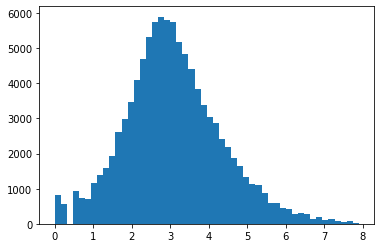

In [31]:
log_num_followers_hist = plt.hist(twitter_data['#Followers_log'], bins=50)
print('Skew coefficient: ', twitter_data['#Followers_log'].skew())

Skew coefficient:  -0.3130054049315858


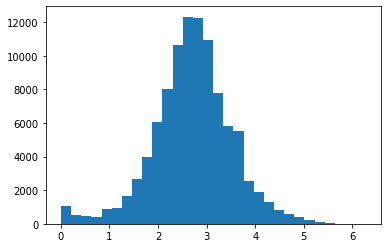

In [32]:
num_friends_hist = plt.hist(twitter_data['#Friends_log'], bins=30)
print('Skew coefficient: ', twitter_data['#Friends_log'].skew())

Skew coefficient:  1.3121065180212501


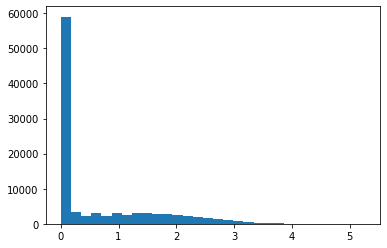

In [33]:
num_friends_hist = plt.hist(twitter_data['#Favorites_log'], bins=30)
print('Skew coefficient: ', twitter_data['#Favorites_log'].skew())

Skew coefficient:  2.0449340408016967


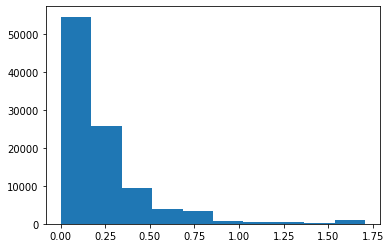

In [34]:
num_friends_hist = plt.hist(twitter_data['#Mentions_log'])
print('Skew coefficient: ', twitter_data['#Mentions_log'].skew())

Skew coefficient:  2.1402405394868054


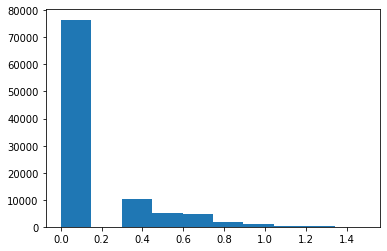

In [35]:
num_friends_hist = plt.hist(twitter_data['#Hashtags_log'])
print('Skew coefficient: ', twitter_data['#Hashtags_log'].skew())

In [36]:
td_new = twitter_data[['#Retweets_log', '#Followers_log', '#Friends_log', '#Favorites_log', '#Hashtags_log', '#Mentions_log', 'Positive_sentiment', 'Negative_sentiment', 'Sun', 'Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Tweet_hour']]
td_new

,#Retweets_log,#Followers_log,#Friends_log,#Favorites_log,#Hashtags_log,#Mentions_log,Positive_sentiment,Negative_sentiment,Sun,Mon,Tue,Wed,Thu,Fri,Sat,Tweet_hour
0,0.000000,2.792392,2.887054,0.000000,0.00000,0.00000,2,-1,0,1,0,0,0,0,0,22
1,1.146128,4.560696,4.286569,1.255273,0.00000,0.00000,1,-4,0,1,0,0,0,0,0,22
2,0.000000,3.700617,3.286456,0.000000,0.00000,0.00000,2,-1,0,1,0,0,0,0,0,22
3,0.000000,3.346353,2.987666,0.000000,0.00000,0.00000,2,-1,0,1,0,0,0,0,0,22
4,1.431364,3.954725,3.694078,1.954243,0.30103,0.00000,2,-1,0,1,0,0,0,0,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000000,1.623249,2.287802,0.000000,0.00000,0.30103,1,-1,0,0,0,1,0,0,0,23
99996,0.301030,3.303628,3.129045,0.778151,0.00000,0.30103,3,-1,0,0,0,1,0,0,0,23
99997,0.000000,2.469822,2.478566,0.000000,0.00000,0.00000,1,-1,0,0,0,0,1,0,0,24
99998,0.000000,2.230449,2.068186,0.000000,0.30103,0.00000,1,-1,0,0,0,0,1,0,0,24


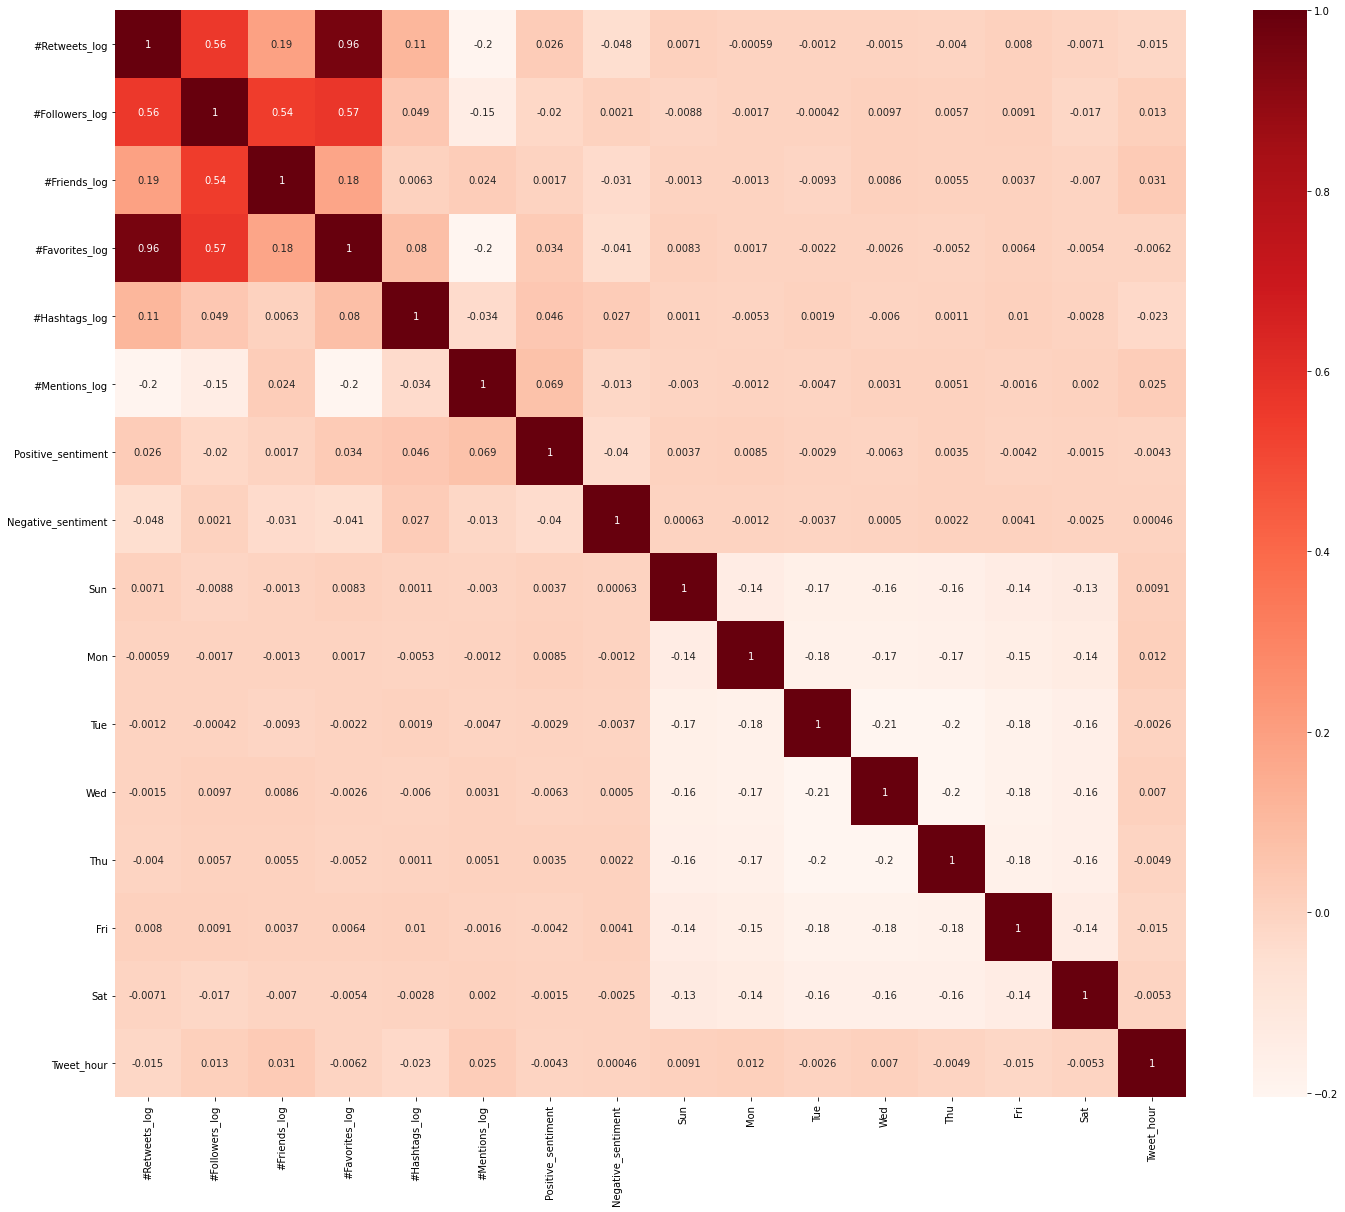

In [37]:
plt.figure(figsize=(24,20))
cor = td_new.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [38]:
sc = StandardScaler()
td_trans = pd.DataFrame(sc.fit_transform(td_new) , columns=td_new.columns)
x = td_trans.drop('#Retweets_log', axis='columns')
y = td_trans['#Retweets_log']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [128]:
# Linear regression with L1 regularization here
reg = LassoCV()
reg.fit(x_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(x_train,y_train))
coef = pd.Series(reg.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 0.000957
Best score using built-in LassoCV: 0.924071
Lasso picked 12 variables and eliminated the other 3 variables


In [129]:
coef

#Followers_log        0.004920
#Friends_log          0.016475
#Favorites_log        0.949483
#Hashtags_log         0.037527
#Mentions_log        -0.001984
Positive_sentiment   -0.007994
Negative_sentiment   -0.008268
Sun                  -0.000082
Mon                  -0.000769
Tue                   0.000000
Wed                   0.000000
Thu                   0.000264
Fri                  -0.000000
Sat                  -0.000324
Tweet_hour           -0.007775
dtype: float64

r^2 value: 0.927


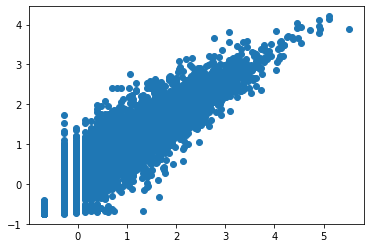

In [130]:
predictions = reg.predict(x_test)
scatter_plot = plt.scatter(y_test, predictions)
print('r^2 value:', '%.3f' % r2_score(y_test, predictions))

Text(0.5, 1.0, 'Feature importance using Lasso Model')

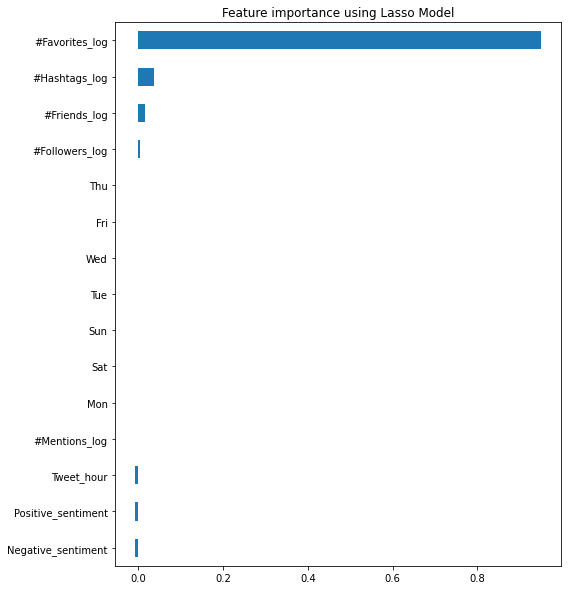

In [131]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [132]:
cv_list = []
# exponentially spaced numbers to get numbers between 2 and 100 but not use every number
depths = np.around(np.exp(np.linspace(np.log(2), np.log(100), 10)))
print(depths)

# 10-fold cross validation
for depth in depths:
    model = tree.DecisionTreeRegressor(max_depth=depth)
    cvs = np.mean(cross_val_score(model, x_train, y_train, cv=10))
    cv_list.append(cvs)
print(cv_list)

[  2.   3.   5.   7.  11.  18.  27.  42.  65. 100.]
[0.876421022423026, 0.9093716894404137, 0.9238093953703009, 0.9266208313376293, 0.9174881286003564, 0.8774830064870267, 0.8567333502408717, 0.8566886769799211, 0.8562757610631587, 0.8556466881294027]


In [133]:
cv_list_2 = []

# Based on results above, score values are highest between depths 5 & 11, now retrain on that interval
for depth in range(5,11):
    model = tree.DecisionTreeRegressor(max_depth=depth)
    cvs = np.mean(cross_val_score(model, x_train, y_train, cv=10))
    cv_list_2.append(cvs)
print(cv_list_2) 

[0.9238093953703009, 0.9258434097879474, 0.9265800709412101, 0.9259226991046686, 0.9243483374710989, 0.9218186264187043]


In [134]:
# Highest score is on depth seven.  Now train model at depth 7.
model = tree.DecisionTreeRegressor(max_depth=7)
model.fit(x_train, y_train)
model.score(x_train, y_train)

0.9297814796460301

r^2 value: 0.930


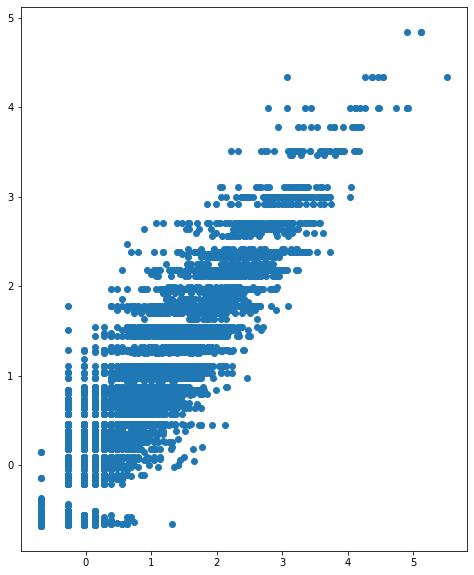

In [135]:
predictions = model.predict(x_test)
scatter_plot = plt.scatter(y_test, predictions)
print('r^2 value:', '%.3f' % r2_score(y_test, predictions))